In [1]:
import numpy as np
import transfer_matrix as tm
from scipy import constants
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
GHz = 1e9 
deg = np.pi/180

sapphire = tm.material( 3.05, 3.38, 2.3e-4, 1.25e-4, 'Sapphire', materialType='uniaxial')
duroid   = tm.material( 1.41, 1.41, 1.2e-3, 1.2e-3, 'RT Duroid', materialType='isotropic')
mullite = tm.material( 2.52, 2.52, 0.0121, 0.0121, 'Mullite', materialType='isotropic')
epoteck = tm.material( 1.7, 1.7, 0., 0., 'Epoteck', materialType='isotropic')

thicknesses = [0.394*tm.mm, 0.04*tm.mm, 0.212*tm.mm, 3.75*tm.mm,3.75*tm.mm,3.75*tm.mm, 0.212*tm.mm, 0.04*tm.mm, 0.394*tm.mm]
thicknesses_plus = [i+0.01*tm.mm for i in thicknesses]
thicknesses_minus = [i-0.01*tm.mm for i in thicknesses]
materials   = [duroid, epoteck, mullite, sapphire, sapphire, sapphire, mullite, epoteck, duroid]
angles      = [0.0, 0.0, 0.0, 0.0, 54.0*tm.deg, 0.0, 0.0, 0.0, 0.0]
anglesplus      = [0.0, 0.0, 0.0, 0.0, 54.0*tm.deg+0.5*tm.deg, 0.0, 0.0, 0.0, 0.0]
anglesminus      = [0.0, 0.0, 0.0, 0.0, 54.0*tm.deg-0.5*tm.deg, 0.0, 0.0, 0.0, 0.0]
hwp         = tm.Stack( thicknesses, materials, angles )
hwp_plus    = tm.Stack( thicknesses_plus, materials, angles )
hwp_minus   = tm.Stack( thicknesses_minus, materials, angles )
hwp_aplus  = tm.Stack( thicknesses, materials, anglesplus ) 
hwp_aminus = tm.Stack( thicknesses, materials, anglesminus )

# TransferMatrix = tm.stackTransferMatrix( hwp, 95*GHz, 0.0*deg, 0*deg, 1.0, 1.0 )
# Mueller        = tm.Mueller( hwp, 95*GHz, 10.0*deg, 0*deg, reflected=False)
# Jones          = tm.Jones( hwp, 95*GHz, 10.0*deg, 0*deg, reflected=False)

In [2]:
# Parameters 
fhwp = 2. # Hz, freq rotation of the HWP
c= constants.c  #speed light 
t_max = (360*np.pi/180)/(2*np.pi*fhwp)
t_range = np.linspace(0,t_max, 100)
hwp_range = np.linspace(0, 360*np.pi/180,100)
phi_ = 26.*np.pi/180

In [3]:
def delta(thickness, frequency, indexOrdinary, indexExtraordinary):
    return 2*np.pi*thickness*np.abs(indexExtraordinary-indexOrdinary)*frequency/c

def Mgrid():
    # Mueller matrix for a grid
    Mgrid_ = np.zeros((4,4))
    Mgrid_[:2,:2] = 0.5
    return Mgrid_

def Mrot(alpha_):
    # Mueller matrix for a rotation
    Mrot_ = np.eye(4)
    Mrot_[1,1] = np.cos(2*alpha_)
    Mrot_[1,2] = np.sin(2*alpha_)
    Mrot_[2,1] = -np.sin(2*alpha_)
    Mrot_[2,2] = np.cos(2*alpha_)
    return Mrot_

def Mhwp(delta_):
    # hwp modulation
    Mhwp_ = np.eye(4) 
    Mhwp_[2,2] = np.cos(delta_)
    Mhwp_[2,3] = -np.sin(delta_)
    Mhwp_[3,2] = np.sin(delta_)
    Mhwp_[3,3] = np.cos(delta_)
    return Mhwp_

In [4]:
def M_tot(angleIncidence, frequency, t_HWP, twodim=False):
    Mueller_      = np.array(tm.Mueller(hwp, frequency*GHz, angleIncidence*deg, 2*np.pi*fhwp*t_HWP, reflected=False))
    Mhwp1_id = Mhwp(np.pi)
    Mhwp2_id = Mrot(phi_).T.dot(Mhwp(np.pi)).dot(Mrot(phi_))
    Mtot_id = Mrot(2*np.pi*fhwp*t_HWP).T.dot(Mhwp1_id).dot(Mhwp2_id).dot(Mhwp1_id).dot(Mrot(2*np.pi*fhwp*t_HWP))
    if twodim==True:
        return Mueller_, Mtot_id
    return Mgrid().dot(Mueller_).dot(Mgrid()), np.dot(Mgrid(), Mtot_id)

In [5]:
def M_tot_var(angleIncidence, frequency, t_HWP, twodim=False):
    Mueller_      = np.array(tm.Mueller(hwp, frequency*GHz, angleIncidence*deg, 2*np.pi*fhwp*t_HWP, reflected=False))
    Mueller_plus  = np.array(tm.Mueller(hwp_plus, frequency*GHz, angleIncidence*deg, 2*np.pi*fhwp*t_HWP, reflected=False))
    Mueller_minus = np.array(tm.Mueller(hwp_minus, frequency*GHz, angleIncidence*deg, 2*np.pi*fhwp*t_HWP, reflected=False))
    if twodim==True:
        return Mueller_
    return Mgrid().dot(Mueller_).dot(Mgrid()), Mgrid().dot(Mueller_plus).dot(Mgrid()), Mgrid().dot(Mueller_minus).dot(Mgrid())

In [6]:
def M_tot_varangle(angleIncidence, frequency, t_HWP, twodim=False):
    Mueller_plus  = np.array(tm.Mueller(hwp_aplus, frequency*GHz, angleIncidence*deg, 2*np.pi*fhwp*t_HWP, reflected=False))
    Mueller_minus = np.array(tm.Mueller(hwp_aminus, frequency*GHz, angleIncidence*deg, 2*np.pi*fhwp*t_HWP, reflected=False))
    return Mgrid().dot(Mueller_plus).dot(Mgrid()), Mgrid().dot(Mueller_minus).dot(Mgrid())

In [7]:
def model_hwp(t_HWP,  a, b, c, phi4, phi2):
    return a+b*np.cos(4*(2*np.pi*fhwp*t_HWP)+4*phi4)+c*np.cos(2*(2*np.pi*fhwp*t_HWP)+2*phi2)

In [8]:
nu_range = np.linspace(60.,196.,151)


initial_stokes = [1, 0, 0, 0]
final_stokes = np.empty((len(t_range), len(nu_range)))

for k,nu_ in enumerate(nu_range):
    for j,t_ in enumerate(t_range):
        Mueller_, Mtot_id = M_tot(0., nu_, t_)
        final_stokes_ = (Mueller_.dot(initial_stokes))[0]
        final_stokes[j,k] = final_stokes_


In [9]:
nu_range = np.linspace(60.,196.,151)


initial_stokes = [1, 0, 0, 0]
final_stokes = np.empty((len(t_range), len(nu_range)))
final_stokes_plus = np.empty((len(t_range), len(nu_range)))
final_stokes_minus = np.empty((len(t_range), len(nu_range)))
final_stokes_plusangle = np.empty((len(t_range), len(nu_range)))
final_stokes_minusangle = np.empty((len(t_range), len(nu_range)))

for k,nu_ in enumerate(nu_range):
    for j,t_ in enumerate(t_range):
        Mueller_, Mueller_plus, Mueller_minus = M_tot_var(0., nu_, t_)
        final_stokes_ = (Mueller_.dot(initial_stokes))[0]
        final_stokes_plus_ = (Mueller_plus.dot(initial_stokes))[0]
        final_stokes_minus_ = (Mueller_minus.dot(initial_stokes))[0]
        
        final_stokes[j,k] = final_stokes_
        final_stokes_plus[j,k] = final_stokes_plus_
        final_stokes_minus[j,k] = final_stokes_minus_

In [10]:
nu_range = np.linspace(60.,196.,151)

initial_stokes = [1, 0, 0, 0]
final_stokes_plusangle = np.empty((len(t_range), len(nu_range)))
final_stokes_minusangle = np.empty((len(t_range), len(nu_range)))

for k,nu_ in enumerate(nu_range):
    for j,t_ in enumerate(t_range):
        Mueller_plus, Mueller_minus = M_tot_varangle(0., nu_, t_)
        final_stokes_plusangles_ = (Mueller_plus.dot(initial_stokes))[0]
        final_stokes_minusangles_ = (Mueller_minus.dot(initial_stokes))[0]
        
        final_stokes_plusangle[j,k] = final_stokes_plusangles_
        final_stokes_minusangle[j,k] = final_stokes_minusangles_

In [11]:
a0_list, a4_list, a2_list, phi4_list, phi2_list, chi2_list = [], [], [], [], [], []
for k,nu_ in enumerate(nu_range):
    popt, pcov = curve_fit(model_hwp, t_range, final_stokes[:,k], bounds=([-1.,-1,-1,-30*deg,0], [1,1,1,30.*deg, 3*np.pi/4]))
    res = final_stokes[:,k] - model_hwp(t_range, *popt)
    chi2_list.append(np.sum(res**2))
    a0_list.append(popt[0])
    a4_list.append(popt[1])
    a2_list.append(popt[2])
    phi4_list.append(popt[3])
    phi2_list.append(popt[4])

chi2_list = np.array(chi2_list)
a0_list = np.array(a0_list)
a4_list = np.array(a4_list)
a2_list = np.array(a2_list)
phi4_list = np.array(phi4_list)
phi2_list = np.array(phi2_list)

In [12]:
a0_list, a4_list, a2_list, phi4_list, phi2_list, chi2_list = [], [], [], [], [], []
a0plus_list, a4plus_list, a2plus_list, phi4plus_list, phi2plus_list, chi2plus_list = [], [], [], [], [], []
a0minus_list, a4minus_list, a2minus_list, phi4minus_list, phi2minus_list, chi2minus_list = [], [], [], [], [], []
a0plusangle_list, a4plusangle_list, a2plusangle_list, phi4plusangle_list, phi2plusangle_list, chi2plusangle_list = [], [], [], [], [], []
a0minusangle_list, a4minusangle_list, a2minusangle_list, phi4minusangle_list, phi2minusangle_list, chi2minusangle_list = [], [], [], [], [], []

for k,nu_ in enumerate(nu_range):
    popt, pcov = curve_fit(model_hwp, t_range, final_stokes[:,k], bounds=([-1.,-1,-1,-30*deg,0], [1,1,1,30.*deg, 3*np.pi/4]))
    popt_plus, pcov_plus = curve_fit(model_hwp, t_range, final_stokes_plus[:,k], bounds=([-1.,-1,-1,-30*deg,0], [1,1,1,30.*deg, 3*np.pi/4]))
    popt_minus, pcov_minus = curve_fit(model_hwp, t_range, final_stokes_minus[:,k], bounds=([-1.,-1,-1,-30*deg,0], [1,1,1,30.*deg, 3*np.pi/4]))
    popt_plusangle, pcov_plusangle = curve_fit(model_hwp, t_range, final_stokes_plusangle[:,k], bounds=([-1.,-1,-1,-30*deg,0], [1,1,1,30.*deg, 3*np.pi/4]))
    popt_minusangle, pcov_minusangle = curve_fit(model_hwp, t_range, final_stokes_minusangle[:,k], bounds=([-1.,-1,-1,-30*deg,0], [1,1,1,30.*deg, 3*np.pi/4]))

    res = final_stokes[:,k] - model_hwp(t_range, *popt)
    chi2_list.append(np.sum(res**2))

    a0_list.append(popt[0])
    a0plus_list.append(popt_plus[0])
    a0plusangle_list.append(popt_plusangle[0])
    a0minus_list.append(popt_minus[0])
    a0minusangle_list.append(popt_minusangle[0])

    a4_list.append(popt[1])
    a4plus_list.append(popt_plus[1])
    a4minus_list.append(popt_minus[1])
    a4plusangle_list.append(popt_plusangle[1])
    a4minusangle_list.append(popt_minusangle[1])

    a2_list.append(popt[2])
    a2plus_list.append(popt_plus[2])
    a2minus_list.append(popt_minus[2])
    a2plusangle_list.append(popt_plusangle[2])
    a2minusangle_list.append(popt_minusangle[2])

    phi4_list.append(popt[3])
    phi4plus_list.append(popt_plus[3])
    phi4minus_list.append(popt_minus[3])
    phi4plusangle_list.append(popt_plusangle[3])
    phi4minusangle_list.append(popt_minusangle[3])

    phi2_list.append(popt[4])
    phi2plus_list.append(popt_plus[4])
    phi2minus_list.append(popt_minus[4])
    phi2plusangle_list.append(popt_plusangle[4])
    phi2minusangle_list.append(popt_minusangle[4])

chi2_list = np.array(chi2_list)
a0_list = np.array(a0_list)
a4_list = np.array(a4_list)
a2_list = np.array(a2_list)
phi4_list = np.array(phi4_list)
phi2_list = np.array(phi2_list)

a0plus_list = np.array(a0plus_list)
a4plus_list = np.array(a4plus_list)
a2plus_list = np.array(a2plus_list)
phi4plus_list = np.array(phi4plus_list)
phi2plus_list = np.array(phi2plus_list)

a0minus_list = np.array(a0minus_list)
a4minus_list = np.array(a4minus_list)
a2minus_list = np.array(a2minus_list)
phi4minus_list = np.array(phi4minus_list)
phi2minus_list = np.array(phi2minus_list)

a0plusangle_list = np.array(a0plusangle_list)
a4plusangle_list = np.array(a4plusangle_list)
a2plusangle_list = np.array(a2plusangle_list)
phi4plusangle_list = np.array(phi4plusangle_list)
phi2plusangle_list = np.array(phi2plusangle_list)

a0minusangle_list = np.array(a0minusangle_list)
a4minusangle_list = np.array(a4minusangle_list)
a2minusangle_list = np.array(a2minusangle_list)
phi4minusangle_list = np.array(phi4minusangle_list)
phi2minusangle_list = np.array(phi2minusangle_list)


Text(0.5, 0, '$\\nu$ [GHz]')

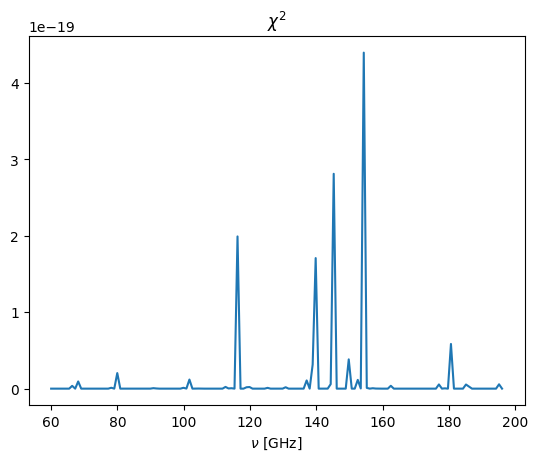

In [13]:
plt.plot(nu_range,chi2_list/(100-5))
plt.title(r'$\chi^2$')
plt.xlabel(r'$\nu$ [GHz]')

In [14]:
a4minusangle_list

array([ 0.1550808 ,  0.16941918,  0.20615137,  0.20692066,  0.17367804,
       -0.16770275, -0.20321272, -0.23444307, -0.21061528, -0.19068374,
       -0.20935618, -0.23790528, -0.2184592 , -0.18786263, -0.19183487,
       -0.22398622, -0.23480528, -0.20884222, -0.19612454, -0.2142225 ,
       -0.23882469, -0.23285504, -0.21785553, -0.22325241, -0.238511  ,
       -0.23299925, -0.21453077, -0.21185955, -0.22757038, -0.23845301,
       -0.22916657, -0.2190413 , -0.22318131, -0.23429356, -0.23677268,
       -0.23192676, -0.23186982, -0.23658972, -0.23625188, -0.22980734,
       -0.22670433, -0.23081863, -0.23588063, -0.2353422 , -0.2318477 ,
       -0.23111149, -0.23358675, -0.23582874, -0.23620613, -0.23622184,
       -0.23687046, -0.23719008, -0.23636494, -0.23511634, -0.2345844 ,
       -0.2349863 , -0.23564654, -0.2358174 , -0.23537989, -0.23493772,
       -0.23518146, -0.23609006, -0.23693823, -0.23718476, -0.23704104,
       -0.23693227, -0.2367454 , -0.23604217, -0.23494295, -0.23

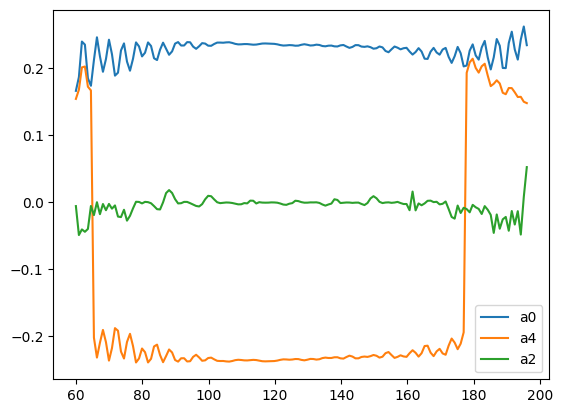

In [15]:
plt.plot(nu_range, a0plusangle_list, label='a0')
plt.plot(nu_range,a4plusangle_list, label='a4')
plt.plot(nu_range, a2_list, label='a2')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


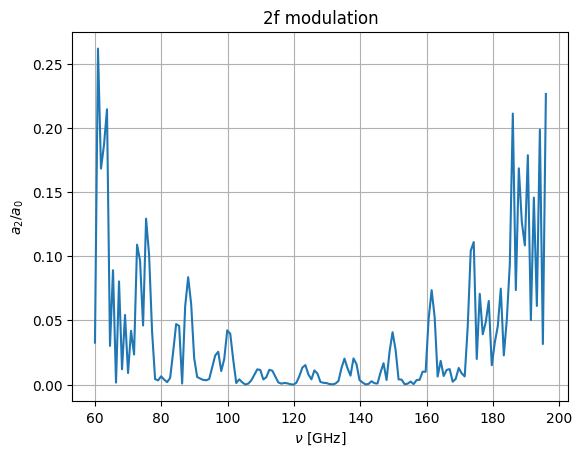

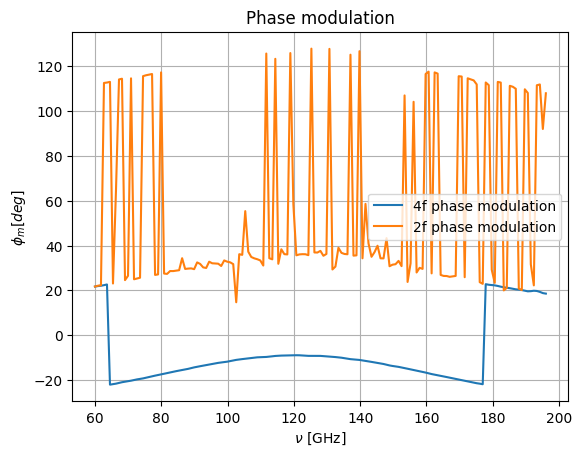

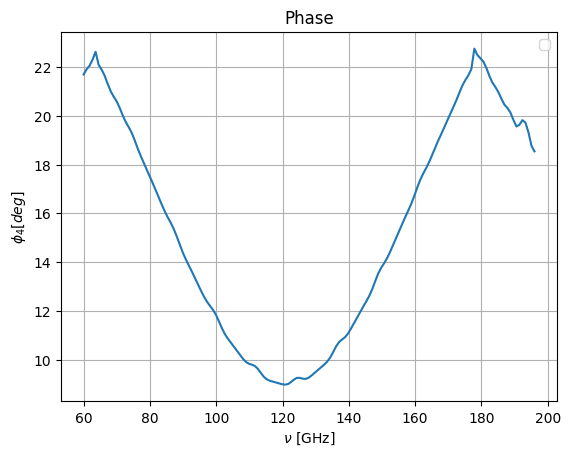

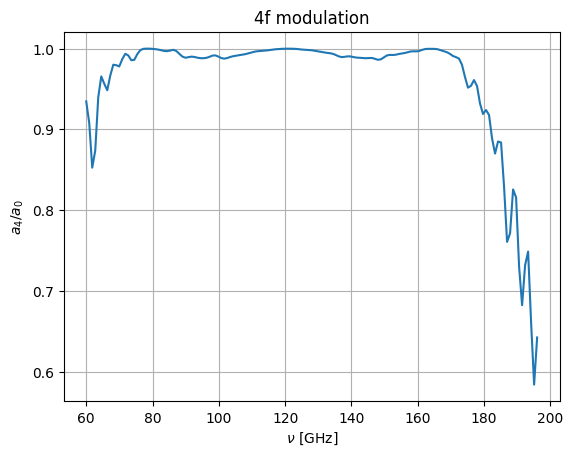

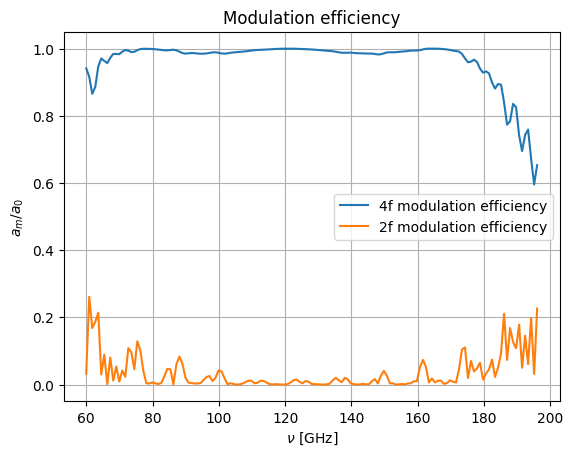

In [16]:
plt.plot(nu_range, np.abs(a2_list/a0_list), label='2f modulation')
plt.ylabel(r'$a_2/a_0$')
plt.xlabel(r'$\nu$ [GHz]')
plt.grid()
plt.title('2f modulation')

plt.figure()
plt.plot(nu_range, phi4_list/deg, label='4f phase modulation')
plt.plot(nu_range, phi2_list/deg, label='2f phase modulation')
plt.ylabel(r'$\phi_m [deg]$')
plt.xlabel(r'$\nu$ [GHz]')
plt.title('Phase modulation')
plt.grid()
plt.legend()


plt.figure()
plt.plot(nu_range, np.abs(phi4_list/deg))
plt.ylabel(r'$\phi_4 [deg]$')
plt.xlabel(r'$\nu$ [GHz]')
plt.title('Phase')
plt.grid()
plt.legend()

plt.figure()
plt.plot(nu_range, np.abs(a4_list/a0_list))
plt.ylabel(r'$a_4/a_0$')
plt.xlabel(r'$\nu$ [GHz]')
plt.grid()
plt.title('4f modulation')

plt.figure()
plt.plot(nu_range, np.abs(a4minusangle_list/a0minusangle_list), label='4f modulation efficiency')
plt.plot(nu_range, np.abs(a2_list/a0_list), label='2f modulation efficiency')
plt.ylabel(r'$a_m/a_0$')
plt.xlabel(r'$\nu$ [GHz]')
plt.grid()
plt.title('Modulation efficiency')
plt.legend()

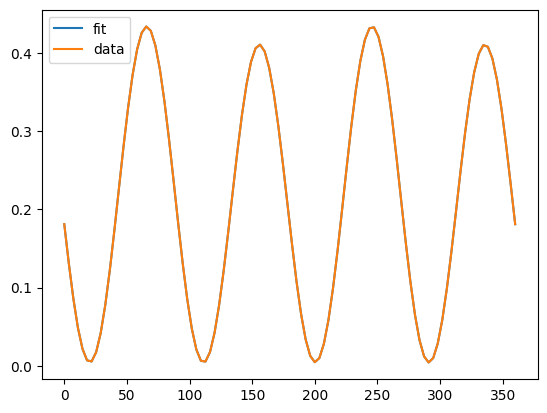

In [17]:
l = 10
plt.plot(2*np.pi*fhwp*t_range/deg, model_hwp(t_range, a0_list[l], a4_list[l], a2_list[l], phi4_list[l], phi2_list[l]), label='fit')
plt.plot(2*np.pi*fhwp*t_range/deg, final_stokes[:,l], label='data')
plt.legend()

In [18]:
import csv

# Specify the file path
file_path = '/Users/ema/Downloads/MF1_AHWP_spectra (2).csv'

# Open the CSV file
with open(file_path, 'r', newline='') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

In [19]:
import pandas as pd

# Specify the file path
file_path = '/Users/ema/Downloads/MF1_AHWP_spectra (2).csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Access the desired column
eps = df['modulation efficiency']
eps_err = df['modulation efficiency STD']
freq = df['frequency (GHz)']
phi4 = df['phase shift (deg)']
phi4_err = df['phase shift STD']

/var/folders/gl/6qsrmpf520nc8v6tng1bkg000000gq/T/ipykernel_17948/2860085831.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


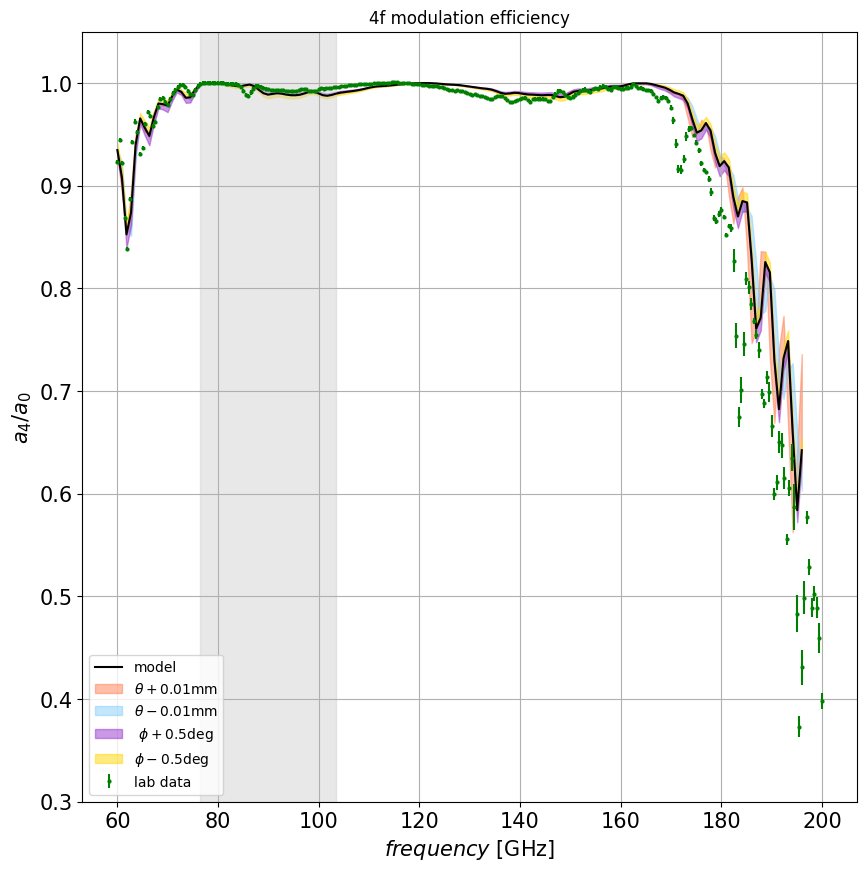

In [20]:
plt.figure(figsize=(10,10))
plt.plot(nu_range, np.abs(a4_list/a0_list), color='black', label=r'model')
plt.fill_between(nu_range, np.abs(a4_list/a0_list),np.abs(a4plus_list/a0plus_list),  color='coral', alpha=0.5, label=r'$\theta + 0.01 $mm')
plt.fill_between(nu_range, np.abs(a4_list/a0_list),np.abs(a4minus_list/a0minus_list),  color='lightskyblue', alpha=0.5, label=r'$\theta - 0.01 $mm')
plt.fill_between(nu_range, np.abs(a4_list/a0_list),np.abs(a4plusangle_list/a0plusangle_list),  color='darkorchid', alpha=0.5, label=r' $\phi + 0.5$deg')
plt.fill_between(nu_range, np.abs(a4_list/a0_list),np.abs(a4minusangle_list/a0minusangle_list),  color='gold', alpha=0.5, label=r'$\phi - 0.5$deg')
plt.errorbar(freq, eps, yerr=eps_err ,color ='green', marker='.', markersize = '4',linestyle='none',label='lab data')
plt.xlabel(r'$frequency$ [GHz]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'$a_4/a_0$', fontsize=15)
plt.title('4f modulation efficiency')
plt.fill_betweenx([-0.5,2.], 90-90*0.15, 90+90*0.15, color='lightgrey', alpha=0.5)
plt.ylim(0.3,1.05)
plt.grid()
plt.legend()

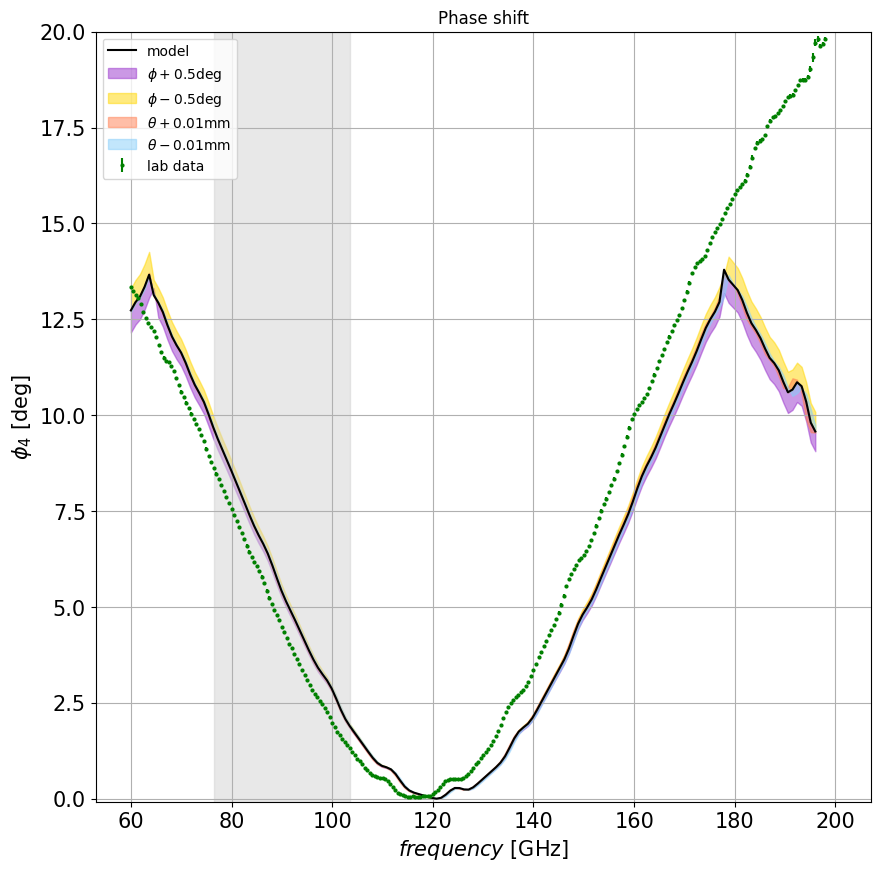

In [21]:
plt.figure(figsize=(10,10))
plt.plot(nu_range, np.abs(phi4_list/deg )-np.min(np.abs(phi4_list/deg)), color='black', label=r'model')
plt.fill_between(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), np.abs(phi4plusangle_list/deg)-np.min(np.abs(phi4plusangle_list/deg)), color='darkorchid', alpha=0.5, label=r'$\phi + 0.5$deg')
plt.fill_between(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), np.abs(phi4minusangle_list/deg)-np.min(np.abs(phi4minusangle_list/deg)), color='gold', alpha=0.5, label=r'$\phi - 0.5$deg')
plt.fill_between(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), np.abs(phi4plus_list/deg)-np.min(np.abs(phi4plus_list/deg)),  color='coral', alpha=0.5, label=r'$\theta + 0.01 $mm')
plt.fill_between(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), np.abs(phi4minus_list/deg)-np.min(np.abs(phi4minus_list/deg)), color='lightskyblue', alpha=0.5, label=r'$\theta - 0.01 $mm')
plt.errorbar(freq, phi4, yerr=phi4_err ,color ='green', marker='.', markersize = '4',linestyle='none',label='lab data')
plt.xlabel(r'$frequency$ [GHz]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'$\phi_4$ [deg]', fontsize=15)
plt.title('Phase shift')
plt.grid()
plt.fill_betweenx([-0.5,26], 90-90*0.15, 90+90*0.15, color='lightgrey', alpha=0.5)
plt.ylim(-0.08, 20)

plt.legend()


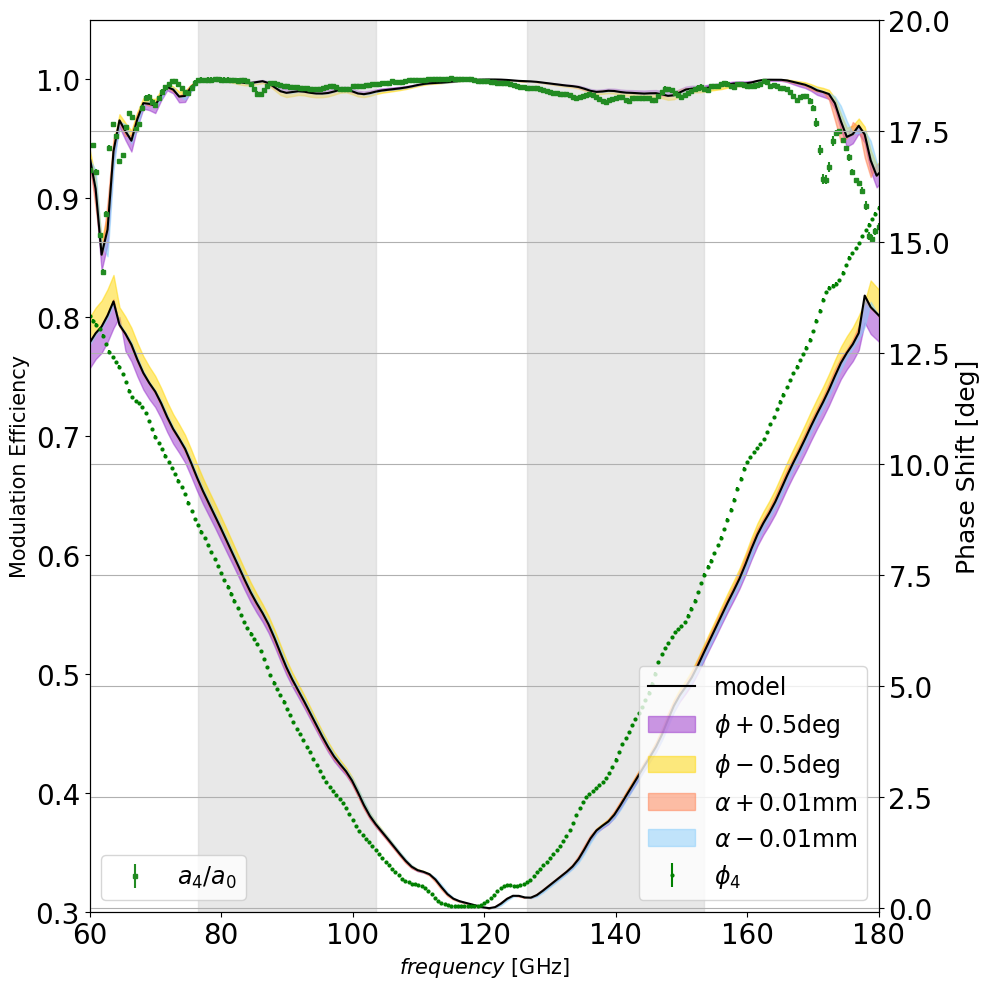

In [76]:
plt.figure(figsize=(10, 10))

# Create the first plot: 4f modulation efficiency
ax1 = plt.gca()
ax1.plot(nu_range, np.abs(a4_list/a0_list), color='black')
ax1.fill_between(nu_range, np.abs(a4_list/a0_list), np.abs(a4plusangle_list/a0plusangle_list), color='darkorchid', alpha=0.5)
ax1.fill_between(nu_range, np.abs(a4_list/a0_list), np.abs(a4minusangle_list/a0minusangle_list), color='gold', alpha=0.5)
ax1.fill_between(nu_range, np.abs(a4_list/a0_list), np.abs(a4plus_list/a0plus_list), color='coral', alpha=0.5)
ax1.fill_between(nu_range, np.abs(a4_list/a0_list), np.abs(a4minus_list/a0minus_list), color='lightskyblue', alpha=0.5)
ax1.errorbar(freq, eps, yerr=eps_err, color='forestgreen', marker='s', markersize='3', linestyle='none', label=r'$a_4/a_0$')
ax1.set_xlabel(r'$frequency$ [GHz]', fontsize=15)
ax1.set_ylabel('Modulation Efficiency', fontsize=15)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
plt.fill_betweenx([-0.5,2.], 90-90*0.15, 90+90*0.15, color='lightgrey', alpha=0.5)
plt.fill_betweenx([-0.5,2.], 140-90*0.15, 140+90*0.15, color='lightgrey', alpha=0.5)
plt.legend(loc='lower left', fontsize=17)
plt.ylim(0.3,1.05)
# Create the second plot: Phase shift
ax2 = ax1.twinx()
ax2.plot(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), color='black', label=r'model')
ax2.fill_between(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), np.abs(phi4plusangle_list/deg)-np.min(np.abs(phi4plusangle_list/deg)), color='darkorchid', alpha=0.5, label=r'$\phi + 0.5 $deg')
ax2.fill_between(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), np.abs(phi4minusangle_list/deg)-np.min(np.abs(phi4minusangle_list/deg)), color='gold', alpha=0.5, label=r'$\phi - 0.5 $deg')
ax2.fill_between(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), np.abs(phi4plus_list/deg)-np.min(np.abs(phi4plus_list/deg)), color='coral', alpha=0.5, label=r'$\alpha + 0.01 $mm')
ax2.fill_between(nu_range, np.abs(phi4_list/deg)-np.min(np.abs(phi4_list/deg)), np.abs(phi4minus_list/deg)-np.min(np.abs(phi4minus_list/deg)), color='lightskyblue', alpha=0.5, label=r'$\alpha - 0.01 $mm')
ax2.errorbar(freq, phi4, yerr=phi4_err, color='green', marker='.', markersize='4', linestyle='none', label=r'$\phi_4$')
ax2.set_ylabel('Phase Shift [deg]', fontsize=18)
ax2.tick_params(axis='y', labelsize=20)
plt.grid(axis='both')
plt.xlim(60, 180)
plt.ylim(-0.08, 20)
plt.legend(loc='lower right', fontsize=17)
plt.tight_layout()
plt.savefig('/Users/ema/these/2024/march/modulation_efficiency_phase_shift.png', dpi=300)
plt.show()


In [47]:
initial_stokes = np.array([1, 1,0,0])

t_max = (360*np.pi/180)/(2*np.pi*2)
t_v = np.linspace(0,t_max, 500)

# Final Stokes vector 
final_stokes = []
final_stokes_id = []
d_t = []
dt_id = []
for t_ in t_v :
    M, M_id = M_tot(0., 90.,t_, twodim=True)
    final_stokes_ = np.dot(M,initial_stokes)
    final_stokes_id_ = np.dot(M_id,initial_stokes)
    dt_ = (M.dot(initial_stokes))[0]
    dt_id_ = (M_id.dot(initial_stokes))[0]
    final_stokes.append(final_stokes_)
    final_stokes_id.append(final_stokes_id_)
    d_t.append(dt_)
    dt_id.append(dt_id_)


final_stokes = np.array(final_stokes)
final_stokes_id = np.array(final_stokes_id)
d_t = np.array(d_t)
dt_id = np.array(dt_id)

I = np.array([final[0] for final in final_stokes])
I_id = np.array([final[0] for final in final_stokes_id])
diff_I = I - I_id
Q = np.array([final[1] for final in final_stokes])
Q_id = np.array([final[1] for final in final_stokes_id])
diff_Q = Q - Q_id
U = np.array([final[2] for final in final_stokes])
U_id = np.array([final[2] for final in final_stokes_id])
diff_U = U - U_id
V = np.array([final[3] for final in final_stokes])
V_id = np.array([final[3] for final in final_stokes_id])
diff_V = V - V_id

In [48]:
14*6+5


89

In [49]:
print(Q)

[-0.49673431 -0.53626378 -0.5744118  -0.61108198 -0.64618165 -0.67962215
 -0.71131901 -0.74119222 -0.76916637 -0.79517088 -0.81914016 -0.84101381
 -0.86073672 -0.87825925 -0.89353734 -0.90653263 -0.91721254 -0.92555038
 -0.93152539 -0.93512281 -0.9363339  -0.93515598 -0.93159244 -0.92565271
 -0.91735224 -0.90671247 -0.89376079 -0.87853043 -0.86106042 -0.84139543
 -0.81958575 -0.79568707 -0.76976038 -0.74187182 -0.7120925  -0.68049833
 -0.6471698  -0.61219181 -0.57565345 -0.53764773 -0.49827142 -0.45762473
 -0.41581111 -0.37293693 -0.32911129 -0.28444567 -0.23905368 -0.19305078
 -0.14655394 -0.09968141 -0.05255238 -0.00528668  0.04199553  0.08917403
  0.1361289   0.18274076  0.22889115  0.27446274  0.31933971  0.363408
  0.40655561  0.44867287  0.48965275  0.5293911   0.56778693  0.60474267
  0.64016441  0.67396212  0.70604993  0.73634629  0.76477422  0.79126147
  0.81574073  0.8381498   0.85843173  0.87653498  0.89241354  0.90602705
  0.91734092  0.92632637  0.93296058  0.93722667  0.9

In [50]:
print(Q_id)


[-0.2419219  -0.19276565 -0.14312051 -0.09311238 -0.0428681   0.00748491
  0.05781893  0.10800631  0.15791976  0.20743269  0.25641953  0.30475603
  0.35231961  0.39898962  0.44464771  0.48917808  0.53246778  0.57440702
  0.61488945  0.65381238  0.6910771   0.72658909  0.7602583   0.79199932
  0.82173166  0.84937991  0.87487394  0.8981491   0.91914636  0.93781246
  0.95410007  0.96796786  0.97938068  0.98830958  0.9947319   0.99863136
  0.99999808  0.99882858  0.99512584  0.98889924  0.98016457  0.96894399
  0.95526595  0.93916515  0.92068242  0.89986464  0.87676461  0.8514409
  0.82395776  0.79438488  0.76279726  0.72927503  0.69390319  0.65677146
  0.61797401  0.57760925  0.53577954  0.49259098  0.4481531   0.40257861
  0.35598308  0.30848471  0.26020395  0.21126326  0.16178676  0.11189993
  0.0617293   0.0114021  -0.03895401 -0.08921132 -0.13924237 -0.18892028
 -0.23811904 -0.28671388 -0.33458155 -0.38160065 -0.42765192 -0.47261858
 -0.51638657 -0.55884489 -0.59988586 -0.63940539 -0.

In [51]:
np.degrees(2*np.pi*fhwp*t_v)[89]-np.degrees(2*np.pi*fhwp*t_v)[42]

33.90781563126252

<Figure size 1000x800 with 0 Axes>

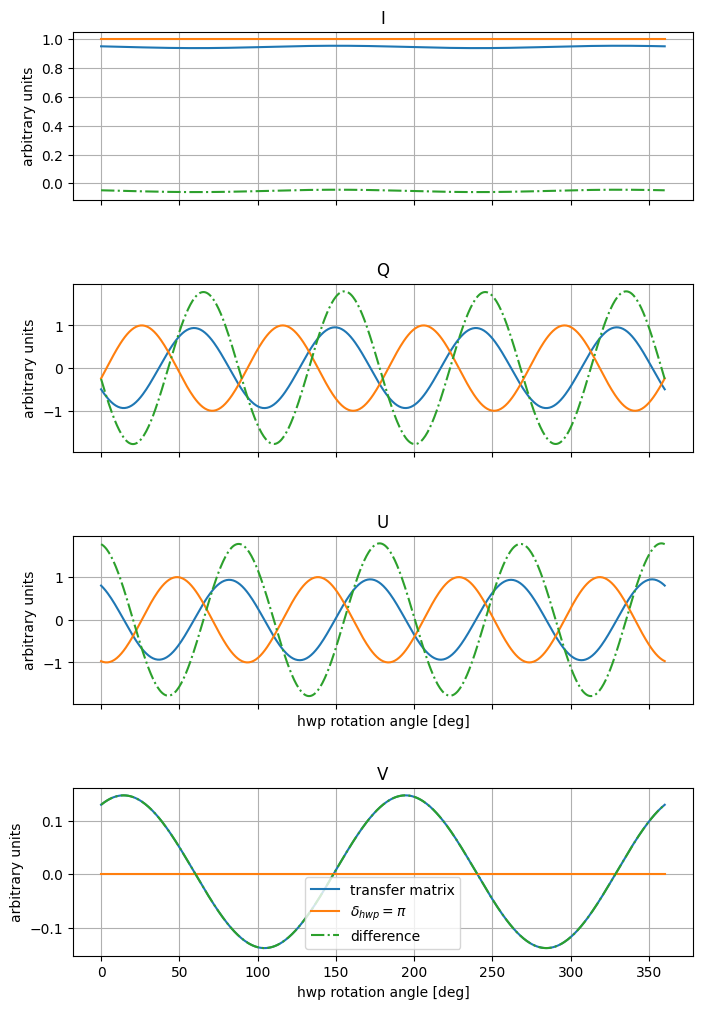

In [52]:
plt.figure(figsize=(10, 8))
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 12), sharex=True, gridspec_kw={'hspace': 0.5})


ax[0].plot(np.degrees(2*np.pi*fhwp*t_v), I)
ax[0].plot(np.degrees(2*np.pi*fhwp*t_v), I_id)
ax[0].plot(np.degrees(2*np.pi*fhwp*t_v), diff_I, '-.')
ax[0].set_ylabel('arbitrary units')
ax[0].set_title(r'I')
ax[0].grid(True)


ax[1].plot(np.degrees(2*np.pi*fhwp*t_v), Q)
ax[1].plot(np.degrees(2*np.pi*fhwp*t_v), Q_id)
ax[1].plot(np.degrees(2*np.pi*fhwp*t_v), diff_Q, '-.')
ax[1].set_ylabel('arbitrary units')
ax[1].set_title(r'Q')
ax[1].grid(True)



ax[2].plot(np.degrees(2*np.pi*fhwp*t_v), U)
ax[2].plot(np.degrees(2*np.pi*fhwp*t_v), U_id)
ax[2].plot(np.degrees(2*np.pi*fhwp*t_v), diff_U, '-.')
ax[2].set_ylabel('arbitrary units')
ax[2].set_xlabel('hwp rotation angle [deg]')
ax[2].set_title(r'U')
ax[2].grid(True)

ax[3].plot(np.degrees(2*np.pi*fhwp*t_v), V, label='transfer matrix')
ax[3].plot(np.degrees(2*np.pi*fhwp*t_v), V_id, label=r'$\delta_{hwp}=\pi$')
ax[3].plot(np.degrees(2*np.pi*fhwp*t_v), diff_V, '-.', label = 'difference')
ax[3].set_ylabel('arbitrary units')
ax[3].set_xlabel('hwp rotation angle [deg]')
ax[3].set_title(r'V')
ax[3].grid(True)
plt.legend(frameon=True)

#plt.savefig('/Users/ema/these /2024/january/note on hwp/plots/{}_incidence.pdf'.format(np.degrees(i_test)))

plt.show()

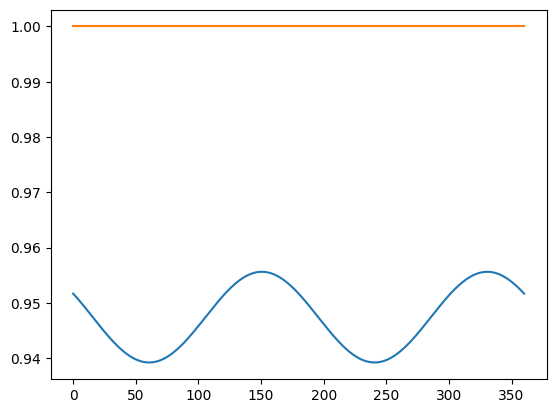

In [53]:
plt.plot(np.degrees(2*np.pi*fhwp*t_v), d_t)
plt.plot(np.degrees(2*np.pi*fhwp*t_v), dt_id)

In [102]:
anglesIncident = np.linspace(0., 17., 101)
nu_v = np.linspace(70.,200.,101)


II = np.empty((len(anglesIncident), len(t_range)), dtype=object)
IQ = np.empty((len(anglesIncident), len(t_range)), dtype=object)
IU = np.empty((len(anglesIncident), len(t_range)), dtype=object)
IV = np.empty((len(anglesIncident), len(t_range)), dtype=object)
QI = np.empty((len(anglesIncident), len(t_range)), dtype=object)
QQ = np.empty((len(anglesIncident), len(t_range)), dtype=object)
QU = np.empty((len(anglesIncident), len(t_range)), dtype=object)
QV = np.empty((len(anglesIncident), len(t_range)), dtype=object)
UI = np.empty((len(anglesIncident), len(t_range)), dtype=object)
UQ = np.empty((len(anglesIncident), len(t_range)), dtype=object)
UU = np.empty((len(anglesIncident), len(t_range)), dtype=object)
UV = np.empty((len(anglesIncident), len(t_range)), dtype=object)
VI = np.empty((len(anglesIncident), len(t_range)), dtype=object)
VQ = np.empty((len(anglesIncident), len(t_range)), dtype=object)
VU = np.empty((len(anglesIncident), len(t_range)), dtype=object)
VV = np.empty((len(anglesIncident), len(t_range)), dtype=object)

for k,nu_ in enumerate (nu_v):
    for j,t_ in enumerate (t_range) :
        M_, M_id = M_tot(0., nu_,t_, twodim=True)
        II[k,j] = M_[0,0]
        IQ[k,j] = M_[0,1]
        IU[k,j] = M_[0,2]
        IV[k,j] = M_[0,3]
        QI[k,j] = M_[1,0]
        QQ[k,j] = M_[1,1]
        QU[k,j] = M_[1,2]
        QV[k,j] = M_[1,3]
        UI[k,j] = M_[2,0]
        UQ[k,j] = M_[2,1]
        UU[k,j] = M_[2,2]
        UV[k,j] = M_[2,3]
        VI[k,j] = M_[3,0]
        VQ[k,j] = M_[3,1]
        VU[k,j] = M_[3,2]
        VV[k,j] = M_[3,3]


In [103]:
print(T)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.06346652 0.06346652 0.06346652 ... 0.06346652 0.06346652 0.06346652]
 [0.12693304 0.12693304 0.12693304 ... 0.12693304 0.12693304 0.12693304]
 ...
 [6.15625227 6.15625227 6.15625227 ... 6.15625227 6.15625227 6.15625227]
 [6.21971879 6.21971879 6.21971879 ... 6.21971879 6.21971879 6.21971879]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]]


In [104]:

II = II.astype(np.float64)
IQ = IQ.astype(np.float64)
IU = IU.astype(np.float64)
IV = IV.astype(np.float64)
QI = QI.astype(np.float64)
QQ = QQ.astype(np.float64)
QU = QU.astype(np.float64)
QV = QV.astype(np.float64)
UI = UI.astype(np.float64)
UQ = UQ.astype(np.float64)
UU = UU.astype(np.float64)
UV = UV.astype(np.float64)
VI = VI.astype(np.float64)
VQ = VQ.astype(np.float64)
VU = VU.astype(np.float64)
VV = VV.astype(np.float64)
II = II.T
IQ = IQ.T
IU = IU.T
IV = IV.T
QI = QI.T
QQ = QQ.T
QU = QU.T
QV = QV.T
UI = UI.T
UQ = UQ.T
UU = UU.T
UV = UV.T
VI = VI.T
VQ = VQ.T
VU = VU.T
VV = VV.T


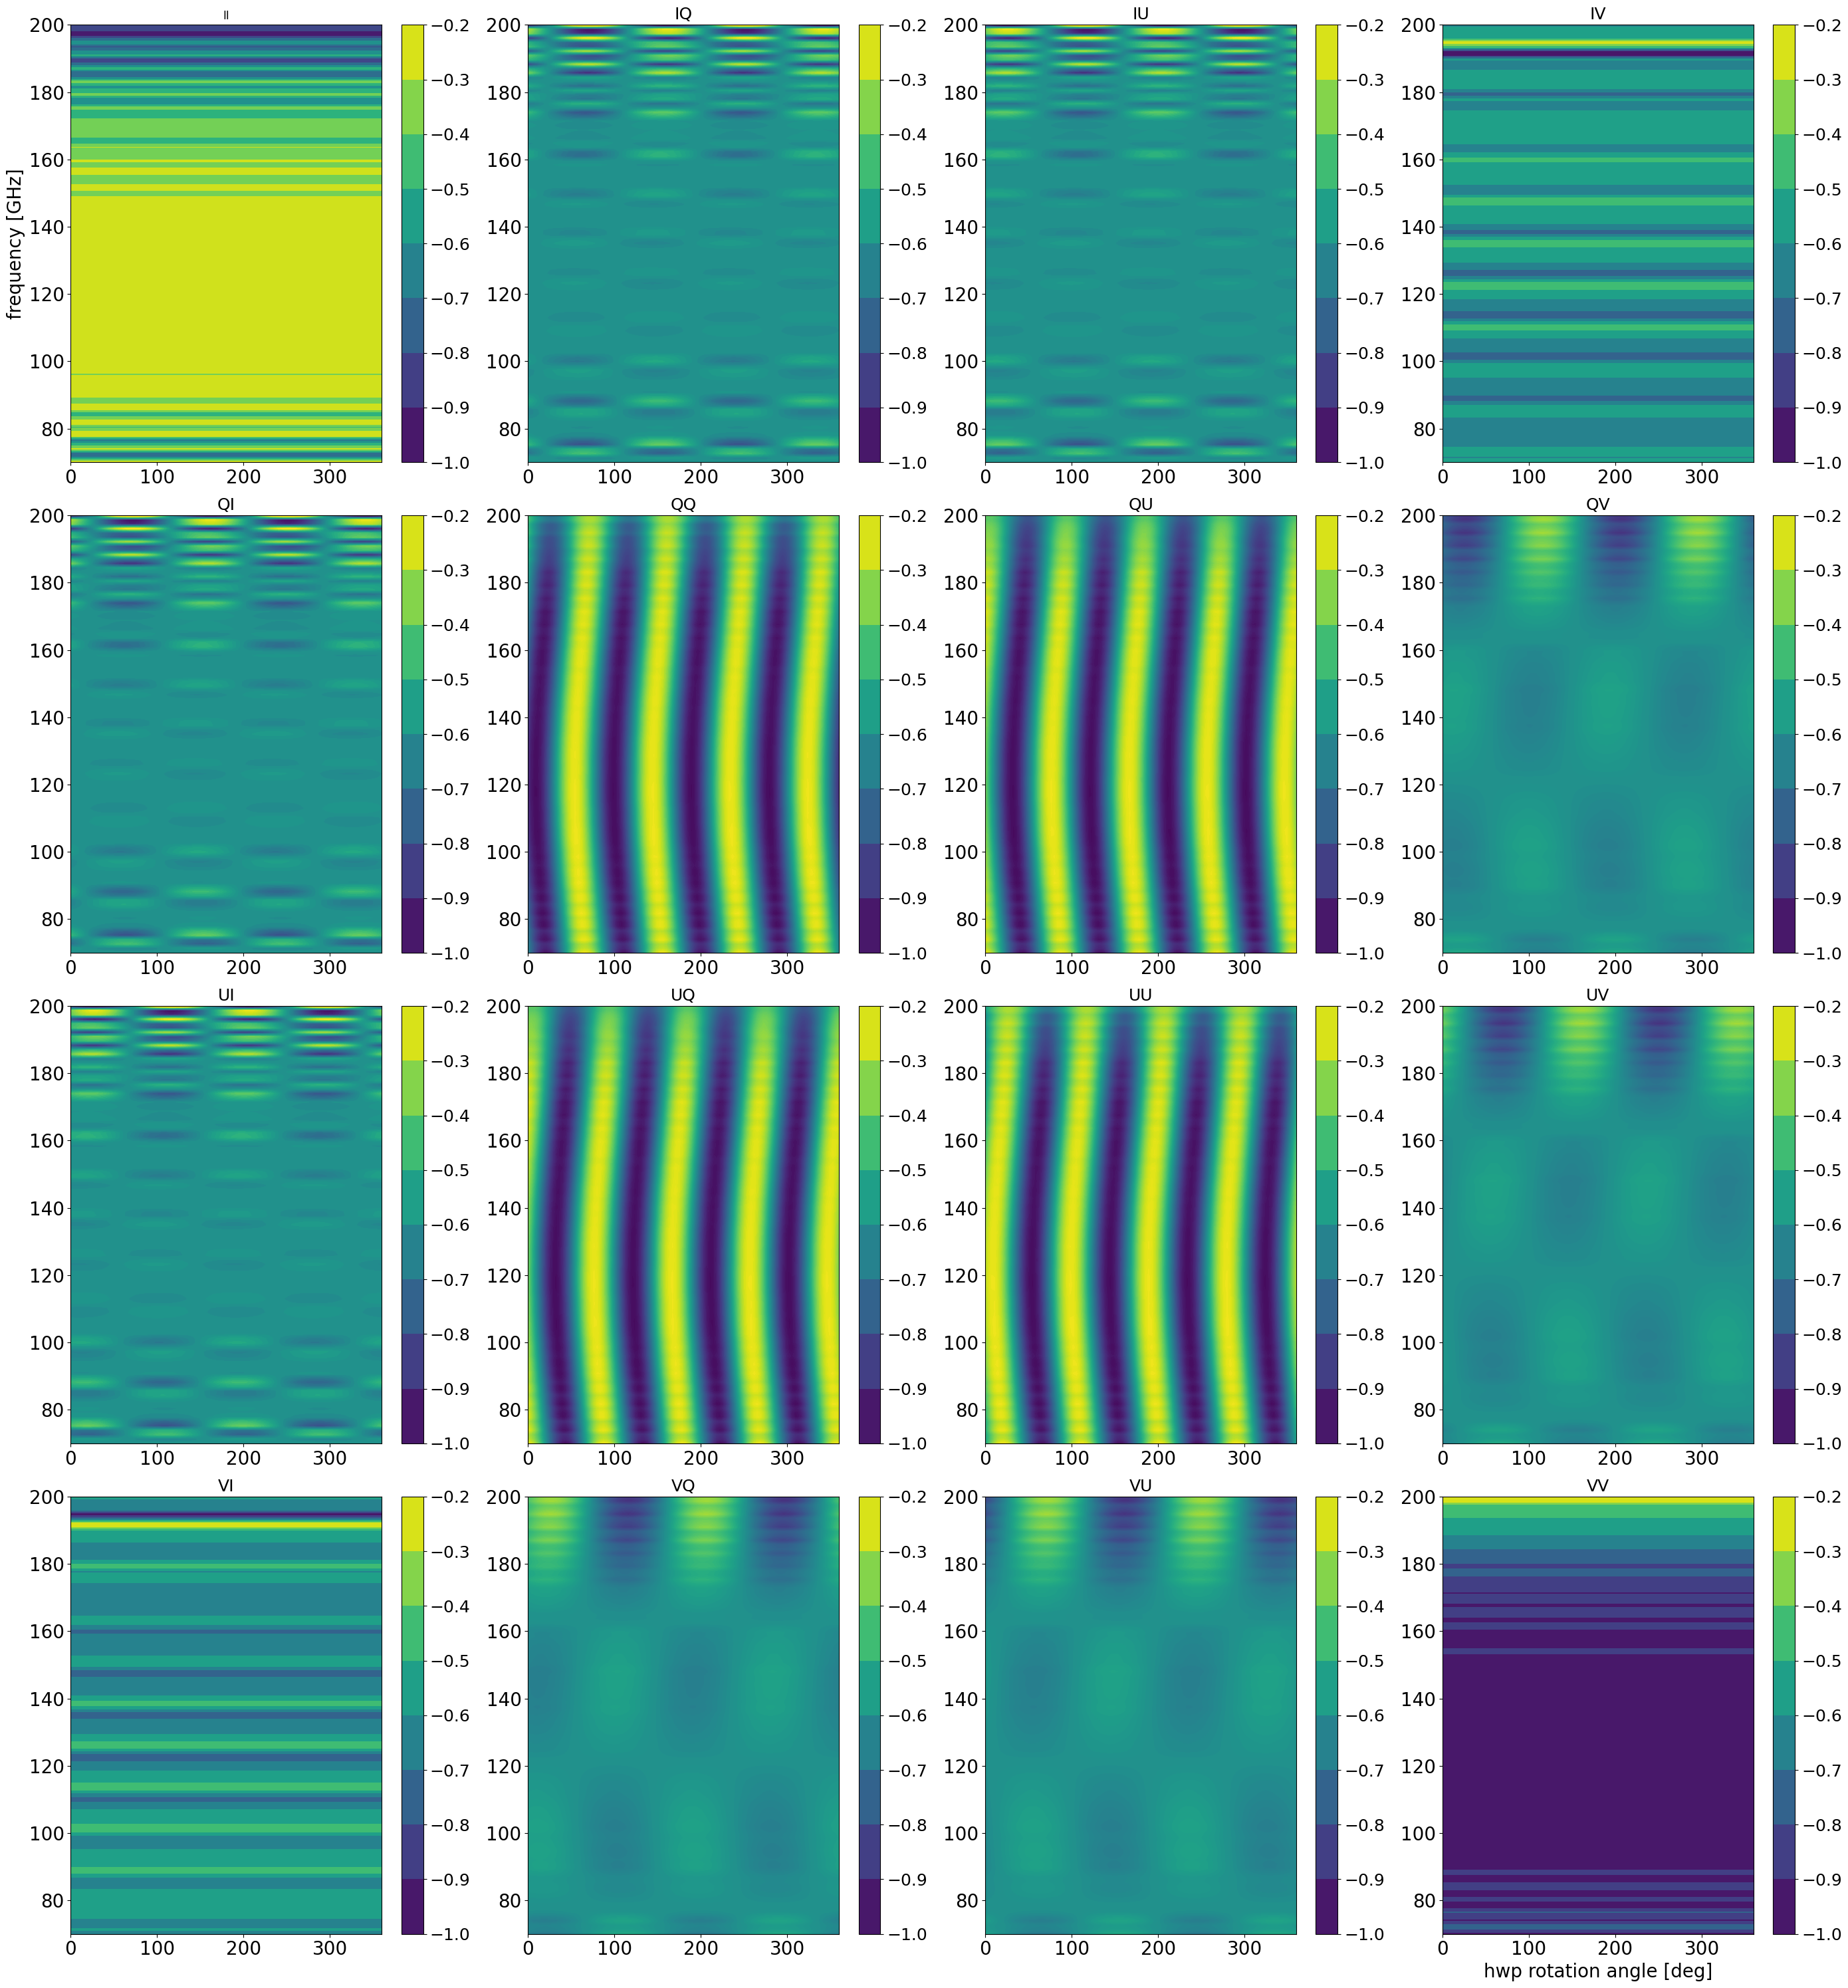

In [171]:
Nu, T = np.meshgrid(nu_v, 2*np.pi*fhwp*t_range)
T_deg = np.degrees(T)
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(28, 30))
level = np.linspace(-0.1, 0.1, 50) 
levelI = np.linspace(-0.01,-0.010, 50) 
levels = np.linspace(-1, 1, 100) 

cax = ax[0, 0].contourf(T_deg, Nu, II)
ax[0, 0].set_title(r'II')
ax[0,0].set_ylabel(r'frequency [GHz]', fontsize=20)


cax = ax[0, 1].contourf(T_deg, Nu, IQ, levels=level)
ax[0, 1].set_title(r'IQ',fontsize=18)


cax = ax[0, 2].contourf(T_deg, Nu, IU,levels=level)
ax[0, 2].set_title(r'IU',fontsize=18)


cax = ax[0, 3].contourf(T_deg, Nu, IV)
ax[0, 3].set_title(r'IV',fontsize=18)


cax = ax[1, 0].contourf(T_deg, Nu, QI,levels=level)
ax[1, 0].set_title(r'QI',fontsize=18)


cax = ax[1, 1].contourf(T_deg, Nu, QQ, levels=levels)
ax[1, 1].set_title(r'QQ',fontsize=18)

cax = ax[1, 2].contourf(T_deg, Nu, QU, levels=levels)
ax[1, 2].set_title(r'QU',fontsize=18)


cax = ax[1, 3].contourf(T_deg, Nu, QV, levels=levels)
ax[1, 3].set_title(r'QV',fontsize=18)


cax = ax[2, 0].contourf(T_deg, Nu, UI,levels=level)
ax[2, 0].set_title(r'UI',fontsize=18)

cax = ax[2, 1].contourf(T_deg, Nu, UQ, levels=levels)
ax[2, 1].set_title(r'UQ',fontsize=18)


cax = ax[2, 2].contourf(T_deg, Nu, UU, levels=levels)
ax[2, 2].set_title(r'UU',fontsize=18)


cax = ax[2, 3].contourf(T_deg, Nu, UV, levels=levels)
ax[2, 3].set_title(r'UV',fontsize=18)


cax = ax[3, 0].contourf(T_deg, Nu, VI)
ax[3, 0].set_title(r'VI',fontsize=18)


cax = ax[3, 1].contourf(T_deg, Nu, VQ, levels=levels)
ax[3, 1].set_title(r'VQ',fontsize=18)


cax = ax[3, 2].contourf(T_deg, Nu, VU, levels=levels)
ax[3, 2].set_title(r'VU',fontsize=18)


cax = ax[3, 3].contourf(T_deg, Nu, VV)
ax[3, 3].set_title(r'VV',fontsize=18)

ax[3,3].set_xlabel(r'hwp rotation angle [deg]', fontsize=20)

for i in range(4):
    for j in range(4):
        ax[i, j].tick_params(axis='x', labelsize=20)
        ax[i, j].tick_params(axis='y', labelsize=20)

        cbar = fig.colorbar(cax, ax=ax[i,j])
        cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('/Users/ema/these/2024/march/transfer_matrix.png', dpi=300)
plt.show()